In [144]:
import os
import re
import numpy as np
import pickle
import math
import mne
from mne.io import read_raw_brainvision
from mne.preprocessing import EOGRegression

def get_rawdata_list(): # get the list of rawdata files with .vhdr extension
    rawdata_dir = 'C:/Users/YSB/Desktop/Data/2022_sternberg_tACS/' # directory where the rawdata is stored
    rawdata_list_total = os.listdir(rawdata_dir) # return all files in the directory without directory itself
    rawdata_list = [os.path.join(rawdata_dir, i) for i in rawdata_list_total if re.search('[0-9].vhdr', i)] # return only files with .vhdr extension
    
    return rawdata_list

def get_montage():
    montage_dir = 'C:/Users/YSB/Desktop/Data/2022_sternberg_tACS/CMA-64_REF.bvef'
    montage = mne.channels.read_custom_montage(montage_dir)
    montage.rename_channels(dict(REF='FCz'))
    
    return montage

def basic_filtering(raw):
    # params
    l_freq = 0.5 # low cut-off frequency
    h_freq = None
    # IIR filter parameters
    iir_params = mne.filter.construct_iir_filter( 
        {'ftype': 'butter', 'order': 4},
        l_freq, None, raw.info['sfreq'],
        'highpass', return_copy=False, verbose=None
    ) 
    
    # bandpass filtering
    raw_filtered = raw.copy().filter(
        l_freq=l_freq, h_freq = h_freq, method='iir', 
        iir_params=iir_params, verbose=None
    ) 
    raw_filtered = raw_filtered.notch_filter(60) # notch filtering
    
    return raw_filtered

def create_v_heog(raw):
    # data
    get_EEG_data = lambda x, y: y.copy().pick_channels([x]).get_data()
    veog = get_EEG_data('Fp1', raw)-get_EEG_data('EOG', raw)
    heog = get_EEG_data('F7', raw)-get_EEG_data('F8', raw)
    
    # info object
    raw_info = mne.create_info(
        ch_names = ['HEOG', 'VEOG'],
        sfreq = raw.info['sfreq'],
        ch_types = 'eog'
    )
    
    # raw object
    temp_raw = mne.io.RawArray(
        data = np.concatenate([heog, veog], axis = 0),
        info = raw_info,
        first_samp = raw.first_samp
    )
    
    # add channels
    raw.add_channels([temp_raw], force_update_info = True);
    raw.drop_channels(['EOG', 'Fp1', 'F7', 'F8'])
    
    return raw

def get_epochs(raw):
    # params
    srate = raw.info['sfreq']
    delaying_sample = math.floor(srate/1000*33)
    tmin = -300/srate
    tmax = (9300-1)/srate

    # implementation
    events, _ = mne.events_from_annotations(raw)
    np.add.at(events[:, 0], (events[:, 2]!=71) & (events[:, 2]!=72) & (events[:, 0]!=0), delaying_sample)
    events_of_interest = mne.pick_events(events, include = [61, 62])
    epochs = mne.Epochs(raw = raw, events = events_of_interest, 
                        tmin = tmin, tmax = tmax, baseline = None,
                        reject = None, preload=True, verbose = None)
    
    return epochs, events

In [3]:
# Basic preprocessing steps
rawdata_list = get_rawdata_list()
montage = get_montage()
raw = read_raw_brainvision(rawdata_list[0], preload=True)
raw.set_channel_types({'EOG':'eog'})
raw.set_montage(montage)
raw_filtered = basic_filtering(raw)

# Mannually check bad channels and interpolate them
mne.set_config('MNE_BROWSER_BACKEND', 'qt')
raw.plot(n_channels=64, duration=240.0, scalings={'eeg':100e-6})
print('Press any key to continue...')
input() # Wait for marking bad channels
raw.interpolate_bads(reset_bads = True, verbose = None)

# VEOG, HEOG channels for Gratton ocular correction
raw = create_v_heog(raw) # no need to return raw object

# Segmentation
epochs, events = get_epochs(raw)



Extracting parameters from C:/Users/YSB/Desktop/Data/2022_sternberg_tACS/tACS_2022_April_SU0001_1.vhdr...
Setting channel info structure...


Reading 0 ... 276699  =      0.000 ...   553.398 secs...


C:\Users\YSB\AppData\Local\Temp\ipykernel_15696\1184415400.py:6: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)



IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.50 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Using qt as 2D backend.
Used Annotations descriptions: ['Comment/actiCAP Data On', 'New Segment/', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 61', 'Stimulus/S 62', 'Stimulus/S 71', 'Stimulus/S 72', 'Stimulus/S 81', 'Stimulus/S 82', 'Stimulus/S 91', 'Stimulus/S 92', 'Stimulus/S 93', 'Stimulus/S 94']
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 9600 original time points ...
0 bad epochs dropped


C:\Users\YSB\AppData\Local\Temp\ipykernel_15696\1184415400.py:14: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads(reset_bads = True, verbose = None)


Channels marked as bad:
['C5', 'Fp2']


In [154]:
from mne.preprocessing import EOGRegression


C:\Users\YSB\AppData\Local\Temp\ipykernel_15696\1784551418.py:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = epochs.average("all").plot(**plot_kwargs)


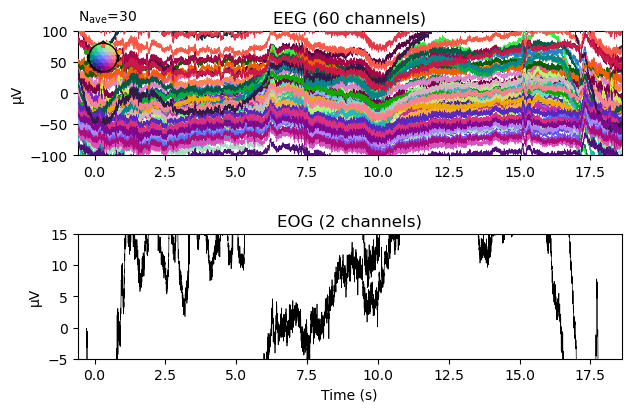

In [159]:
# we'll try to keep a consistent ylim across figures
plot_kwargs = dict(picks="all", ylim=dict(eeg=(-100, 100), eog=(-5, 15)))

# plot the evoked for the EEG and the EOG sensors
fig = epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: VEOG, HEOG


[done]
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
No projector specified for this dataset. Please consider the method self.add_proj.


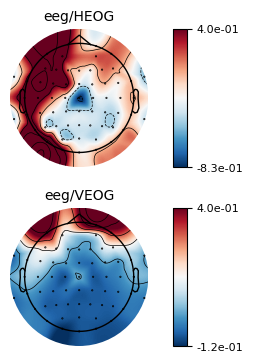

In [163]:
# create epochs with the evoked subtracted out
epochs_sub = epochs.copy().subtract_evoked()

# perform regression
epochs_sub.set_eeg_reference("average")
model_sub = EOGRegression(picks="eeg", picks_artifact="eog").fit(epochs_sub)
fig = model_sub.plot(vlim=(None, 0.4))
fig.set_size_inches(3, 2)



In [104]:
# raw_info = raw.copy().info
# channel_char = ['ch_name', 'coil_type', 'kind', 'logno', 'scanno', 'cal', 'range', 'loc', 'unit', 'unit_mul', 'coord_frame']
# test_list = [[x[dict_type] for x in raw.info['chs']] for dict_type in channel_char]
# [print(set(test_list[x])) for x in range(len(test_list)) if x !=7]

# eog_chs = raw.info['chs'][np.argwhere([raw.info['chs'][x]['ch_name']=='EOG' for x in range(len(raw.info['chs']))])[0][0]]
# veog_chs, heog_chs = eog_chs.copy(), eog_chs.copy()
# veog_chs['ch_name'], heog_chs['ch_name'] = 'VEOG', 'HEOG'
# veog_chs['logno'], heog_chs['logno'] = 65, 66
# veog_chs['scanno'], heog_chs['scanno'] = 65, 66